In [1]:
import sys, os
import pandas as pd
import dask.dataframe as dd
import numpy as np
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import seaborn as sns

datapath = 'src/data'
# datapath = '/media/apeters/Extreme SSD/Working'
callvariant = 'speed' #'heading'
EUvariant = '_EEZ' #''
filename = 'portcalls_' + callvariant + '_EU'


In [2]:
os.getcwd()

'/home/apeters/Documents/Research/BulkShipDev'

In [3]:
ais_bulkers_EU = dd.read_parquet(os.path.join(datapath, 'AIS', 'ais_bulkers_trips_EU_power'))

In [4]:
ais_bulkers_EU.columns

Index(['timestamp', 'latitude', 'longitude', 'speed', 'implied_speed',
       'draught', 'distance', 'time_interval', 'interpolated',
       'draught_interpolated', 'phase', 'pot_in_port', 'pot_trip', 'origin',
       'EU', 'in_port', 'year', 'trip', 'work', 'Dwt', 'Draught..m.',
       'Service.Speed..knots.', 'W_component', 'ME_W_ref', 'ME_SFC_base',
       'AE_SFC_base', 'Boiler_SFC_base', 'ME_W', 'AE_W', 'Boiler_W'],
      dtype='object')

In [5]:
ais_bulkers_EU.head()

,timestamp,latitude,longitude,speed,implied_speed,draught,distance,time_interval,interpolated,draught_interpolated,...,Draught..m.,Service.Speed..knots.,W_component,ME_W_ref,ME_SFC_base,AE_SFC_base,Boiler_SFC_base,ME_W,AE_W,Boiler_W
imo,,,,,,,,,,,,,,,,,,,,,
-8000836,2019-01-01 00:22:45+00:00,37.618450,24.146124,10.898438,NaN,7.800781,NaN,NaN,False,False,...,7.92,14.0,0.000117,4781.0,215.0,225.0,340.0,2808.610166,190.0,0.0
-8000836,2019-01-01 01:24:29.749999200+00:00,37.467651,24.020382,10.546900,NaN,7.800781,10.853785,1.029097,True,True,...,7.92,14.0,0.000117,4781.0,215.0,225.0,340.0,2545.500446,190.0,0.0
-8000836,2019-01-01 02:26:14.499998400+00:00,37.316719,23.895142,10.547385,NaN,7.800781,10.854285,1.029097,True,True,...,7.92,14.0,0.000117,4781.0,215.0,225.0,340.0,2545.851909,190.0,0.0
-8000836,2019-01-01 03:27:59.250001200+00:00,37.165646,23.770399,10.547709,NaN,7.800781,10.854618,1.029097,True,True,...,7.92,14.0,0.000117,4781.0,215.0,225.0,340.0,2546.086041,190.0,0.0
-8000836,2019-01-01 04:29:44.000000400+00:00,37.014442,23.646152,10.547871,NaN,7.800781,10.854784,1.029097,True,True,...,7.92,14.0,0.000117,4781.0,215.0,225.0,340.0,2546.203372,190.0,0.0


# Check relative speed for entire EU data set

In [6]:
ais_bulkers_EU['rel_speed'] = ais_bulkers_EU['speed']/ais_bulkers_EU['Service.Speed..knots.']
relspeed_EU = ais_bulkers_EU['rel_speed'].compute()
relspeed_EU.index.nunique()

4893

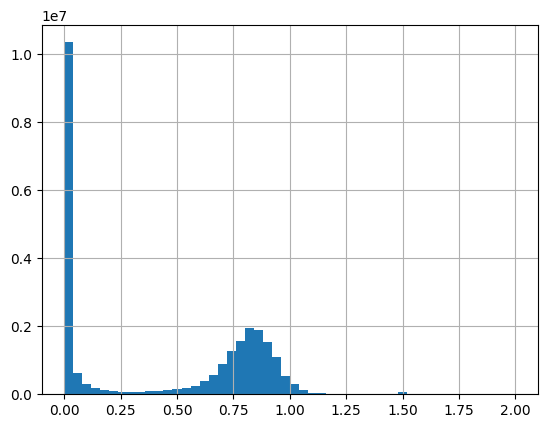

In [7]:
ax = relspeed_EU[relspeed_EU < 2].hist(bins=50)
plt.show()

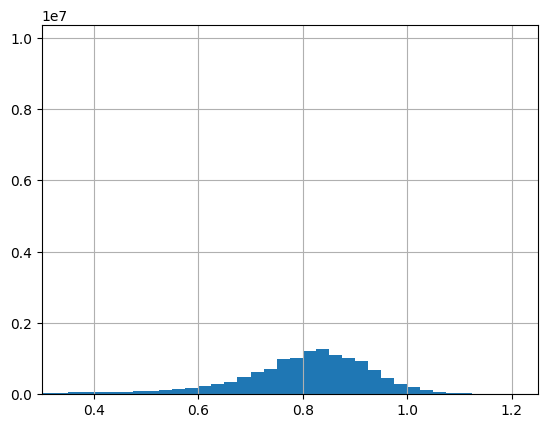

In [8]:
ax = relspeed_EU[relspeed_EU < 1.25].hist(bins=50)
ax.set_xlim(0.3, 1.25)
plt.show()

# Check relative speed for matched dataset used in ML

In [9]:
distance_matched_df = pd.read_csv("src/tracked_data/df_ml_abs_all.csv")
distance_matched_imo = distance_matched_df['imo'].drop_duplicates()
len(distance_matched_imo)

1818

In [10]:
distance_matched_imo

0       9469467
1       9558074
2       9439125
3       9325025
5       9271339
         ...   
2136   -9717515
2137   -9700811
2138   -9802695
2140   -9882061
2141   -9758961
Name: imo, Length: 1818, dtype: int64

<Axes: >

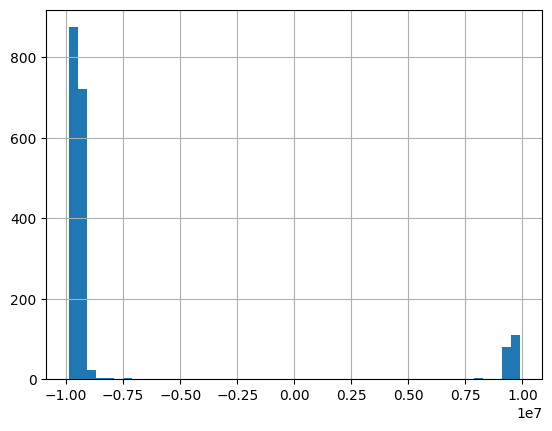

In [11]:
distance_matched_imo.hist(bins=50)

In [12]:
ais_bulkers_ML = ais_bulkers_EU.loc[np.isin(ais_bulkers_EU.index.values, distance_matched_imo)]
ais_bulkers_ML['rel_speed'] = ais_bulkers_ML['speed']/ais_bulkers_ML['Service.Speed..knots.']
relspeed_ML = ais_bulkers_ML['rel_speed'].compute()
relspeed_ML.index.nunique()

1818

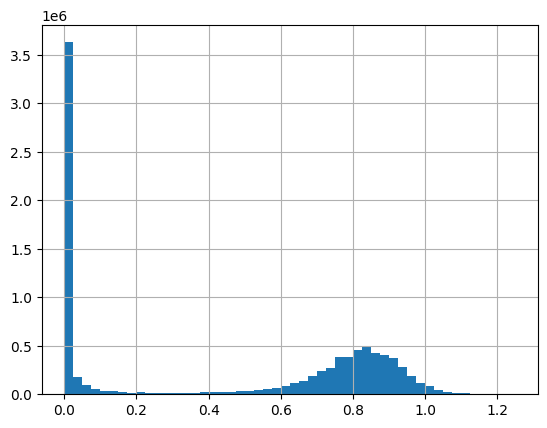

In [13]:
ax = relspeed_ML[relspeed_ML < 1.25].hist(bins=50)
plt.show()

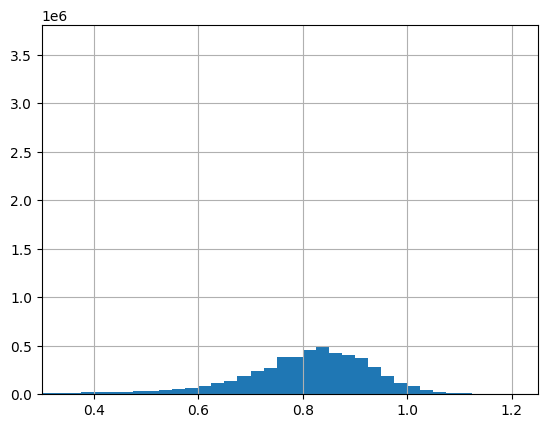

In [14]:
ax = relspeed_ML[relspeed_ML < 1.25].hist(bins=50)
ax.set_xlim(0.3, 1.25)
plt.show()

# By year

In [15]:
relspeed_ML_year = ais_bulkers_ML[['rel_speed', 'year']].compute()


In [16]:
relspeed_ML_year.head()

,rel_speed,year
imo,,
-7926162,0.686458,2019
-7926162,0.666667,2019
-7926162,0.686458,2019
-7926162,0.686458,2019
-7926162,0.706242,2019


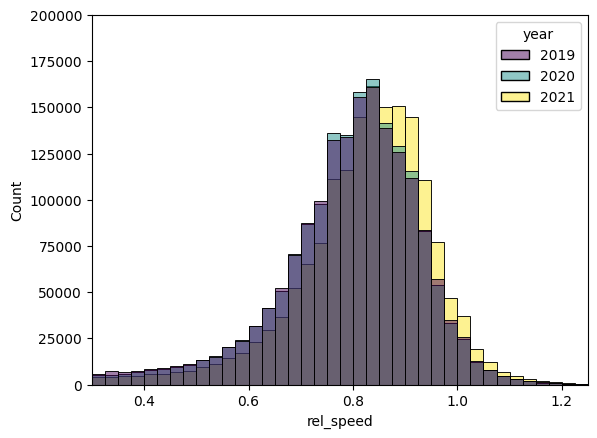

In [17]:
sns.histplot(
    data=relspeed_ML_year.loc[relspeed_ML_year['rel_speed'] < 1.25],
    x='rel_speed',
    hue='year',
    bins=50,
    palette='viridis'
)

plt.xlim(0.3, 1.25)
plt.ylim(0, 0.2e6)
plt.show()

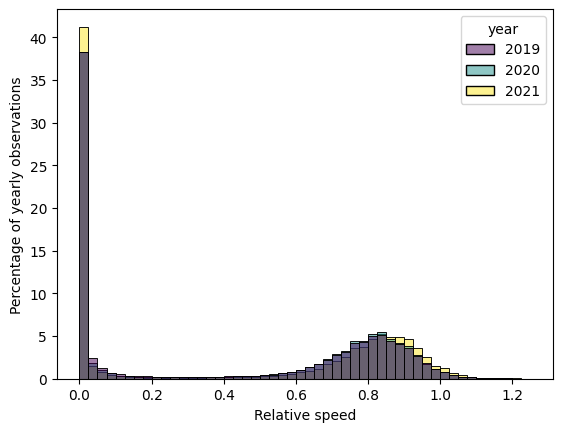

In [18]:
sns.histplot(
    data=relspeed_ML_year.loc[relspeed_ML_year['rel_speed'] < 1.25],
    x='rel_speed',
    hue='year',
    bins=50,
    palette='viridis',
    stat='percent',
    common_norm=False
)

# add label
plt.xlabel('Relative speed')
plt.ylabel('Percentage of yearly observations')
plt.show()

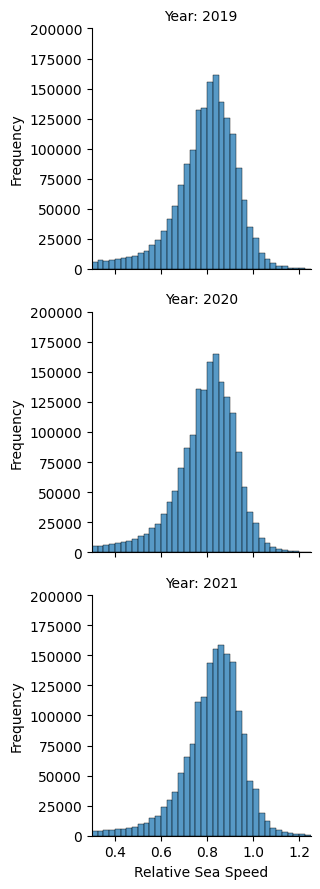

In [19]:
g = sns.FacetGrid(
    relspeed_ML_year.loc[relspeed_ML_year['rel_speed'] < 1.25],
    col='year',
    col_wrap=1,
)

g.map(sns.histplot, 'rel_speed', bins=50, kde=False)
g.set(xlim=(0.3, 1.25), ylim=(0, 0.2e6))

# Add titles and labels
g.set_titles(col_template='Year: {col_name}')
g.set_axis_labels('Relative Sea Speed', 'Frequency')

# Show the plot
plt.show()

# Compare the two

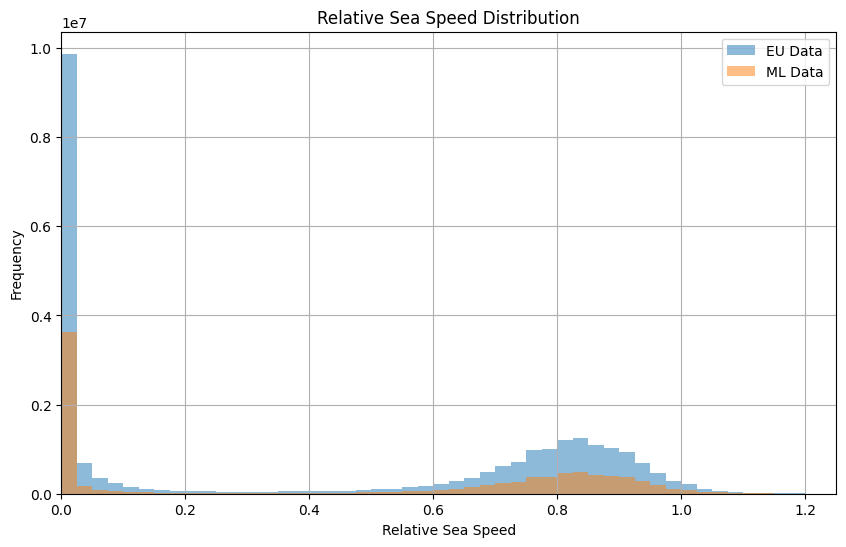

In [20]:
plt.figure(figsize=(10, 6))

# Plot relspeed_EU
ax1 = relspeed_EU[relspeed_EU < 1.25].hist(bins=50, alpha=0.5, label='EU Data')

# Plot relspeed_ML
relspeed_ML[relspeed_ML < 1.25].hist(bins=50, alpha=0.5, label='ML Data', ax = ax1)

plt.xlim(0, 1.25)
plt.xlabel('Relative Sea Speed')
plt.ylabel('Frequency')
plt.title('Relative Sea Speed Distribution')
plt.legend()
plt.show()

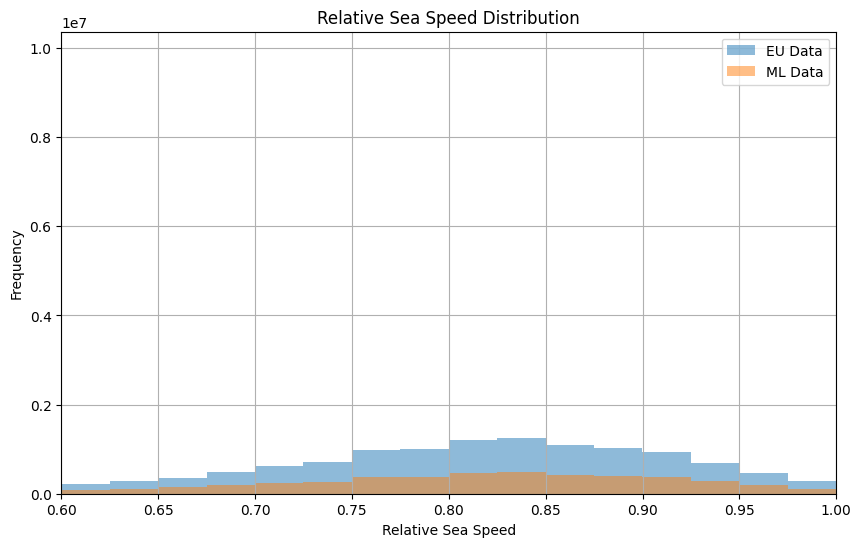

In [21]:
plt.figure(figsize=(10, 6))

# Plot relspeed_EU
ax1 = relspeed_EU[relspeed_EU < 1.25].hist(bins=50, alpha=0.5, label='EU Data')

# Plot relspeed_ML
relspeed_ML[relspeed_ML < 1.25].hist(bins=50, alpha=0.5, label='ML Data', ax = ax1)

plt.xlim(0.6, 1)
plt.xlabel('Relative Sea Speed')
plt.ylabel('Frequency')
plt.title('Relative Sea Speed Distribution')
plt.legend()
plt.show()